# Visualise time series of counts and number of samples
Plots time series of raw counts and counts normalised by total counts per year

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib.colors import ListedColormap

def query_tree(tdf,search_term):
    mesh_list = []
    tlist = tdf[tdf.mesh_id==search_term].mesh_treenumbers.tolist()
    for it in tlist:
        nchar = len(it)
        mesh = tdf[tdf.mesh_treenumbers.str[:nchar]==it].mesh_id.to_list()
        mesh_list += mesh
    return np.unique(mesh_list)

def query_tags(tadf, mesh_list, time_range):
    min_date = int(time_range[0])
    max_date = int(time_range[1])
    match_df = tadf.loc[(np.isin(tadf.mesh_id, mesh_list))&(tadf.year<=max_date)&(tadf.year>=min_date),:] # find matches for the mesh list
    return match_df

def get_counts_per_year(matchdf,time_range):
    # counts per year
    ts = matchdf[['geo_id', 'year', 'aux']].groupby(['geo_id', 'year']).mean().reset_index()[['geo_id', 'year']]
    cpy = ts.groupby('year').size().reset_index(name='c')
    # make sure that all years are in df
    all_years = pd.DataFrame(pd.Series(np.arange(int(time_range[0]), int(time_range[1]),1)), columns = ['year'])
    all_years['aux'] = 1
    cpy_merge = pd.merge(all_years, cpy, on = 'year', how='outer')
    cpy_merge = cpy_merge.drop('aux', axis = 1)
    cpy_merge.loc[cpy_merge.c.isnull(), 'c'] = 0
    return cpy_merge

def get_samples_per_year(matchdf,time_range):
    ts = matchdf.groupby(['geo_id', 'year']).nsamples.mean().reset_index()
    spy = ts.groupby('year').nsamples.sum().reset_index()
    all_years = pd.DataFrame(pd.Series(np.arange(int(time_range[0]), int(time_range[1]),1)), columns = ['year'])
    all_years['aux'] = 1
    spy = pd.merge(all_years, spy, on = 'year', how='outer')
    spy = spy.drop('aux', axis = 1)
    spy.loc[spy.nsamples.isnull(), 'nsamples'] = 0
    return spy

def normalise_it(df):
    df['c_norm'] = (df.c)/(df.c.sum())
    return df

def add_all_years(p, time_range):
    all_years = pd.DataFrame(pd.Series(np.arange(int(time_range[0]), int(time_range[1]),1)), columns = ['year'])
    all_years['aux'] = 1
    mesh = p.mesh_heading.unique()[0]
    p_merge = pd.merge(all_years, p, on = 'year', how='outer')
    p_merge = p_merge.drop('aux', axis = 1)
    p_merge.loc[p_merge.n.isnull(), 'n'] = 0
    p_merge.loc[p_merge.mesh_heading.isnull(), 'mesh_heading'] = mesh
    return p_merge


path = '../../data/final'

# load tree
tree_file = 'mesh.pkl'
trdf = pd.read_pickle(os.path.join(path, tree_file))

# load tags
tag_file ='geo_filtered.pkl'
tadf = pd.read_pickle(os.path.join(path, tag_file))
tadf['year'] = (tadf.date.str[:4]).astype(int) # year
tadf = pd.merge(tadf,trdf[['mesh_id', 'mesh_treenumbers']], on='mesh_id', how='left')

# load top topics based on n series
count_file ='meshids_rankedby_NSeries.pkl'
countsdf = pd.read_pickle(os.path.join(path,count_file))
countsdf = pd.merge(countsdf,trdf, on='mesh_id', how='left')
countsdf = countsdf.loc[np.isin(countsdf.category, ['C'])].reset_index(drop=True)

vizpath = '../../reports/figures/desc'
if os.path.isdir(vizpath)==False:
    os.mkdir(vizpath)

min_year = '2000'
max_year = '2017'
time_range = [min_year, max_year]

# Load dataframes if they have already been generated

In [16]:
sampledf = pd.read_pickle('../../data/final/samplesbyyear_for_plotting.pkl')
countdf = pd.read_pickle('../../data/final/countsbyyear_for_plotting.pkl')
top_d_df = pd.read_pickle('../../data/final/top_diseases_for_plotting.pkl')

# Plot study counts or samples?

In [17]:
counts_or_samples = 1

True

# Pie chart for main categories (samples)

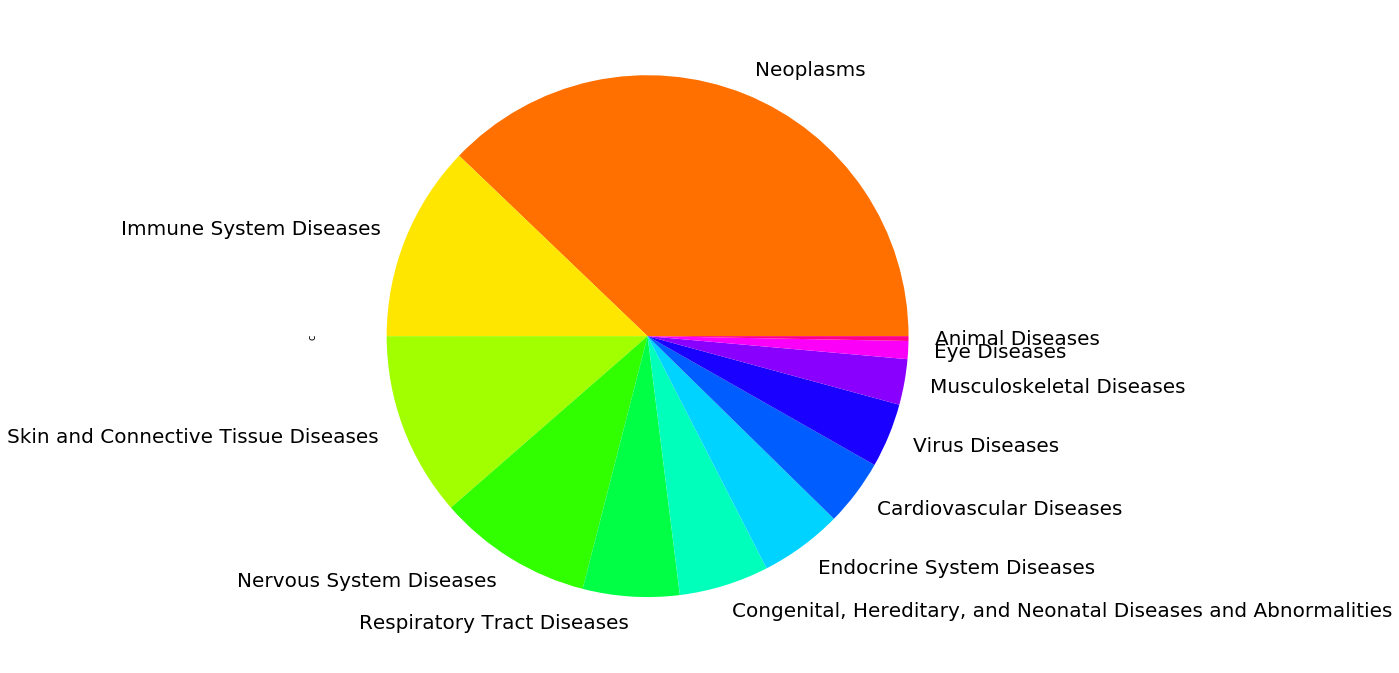

In [4]:
file = 'pie.pdf'
filename = os.path.join(vizpath, file)

sampledf = pd.read_pickle('../../data/final/samplesbyyear_for_plotting.pkl')
sampledf = sampledf.drop_duplicates()
total_samples = sampledf.groupby('mesh_heading').sum().reset_index()
total_samples = pd.merge(total_samples, countsdf[['mesh_heading','mesh_treenumbers']], on='mesh_heading', how='left')
total_samples = total_samples[['mesh_heading', 'c', 'mesh_treenumbers']].drop_duplicates()
my_cmap_main = sns.color_palette("hsv",10).as_hex()

fig,ax =plt.subplots(1,1, figsize=(20,12))
my_cmap_main = sns.color_palette("hsv",12).as_hex()
l1 = total_samples.loc[total_samples.mesh_treenumbers.str.len() ==3,['mesh_heading', 'c']].drop_duplicates()
l1 = l1[~np.isin(l1.mesh_heading,['Occupational Diseases','Parasitic Diseases', 'Wounds and Injuries'])]
l1 = l1.sort_values('c', ascending=False)
l1 = l1[['mesh_heading','c']].set_index('mesh_heading')
l1.plot(kind='pie', subplots=True, figsize=(8, 8),legend=False, fontsize=20, ax = ax, colors=my_cmap_main)

plt.savefig(filename, papertype = 'a4', orientation = 'landscape', format = 'pdf') 

# Plot time series of sample counts for main categories

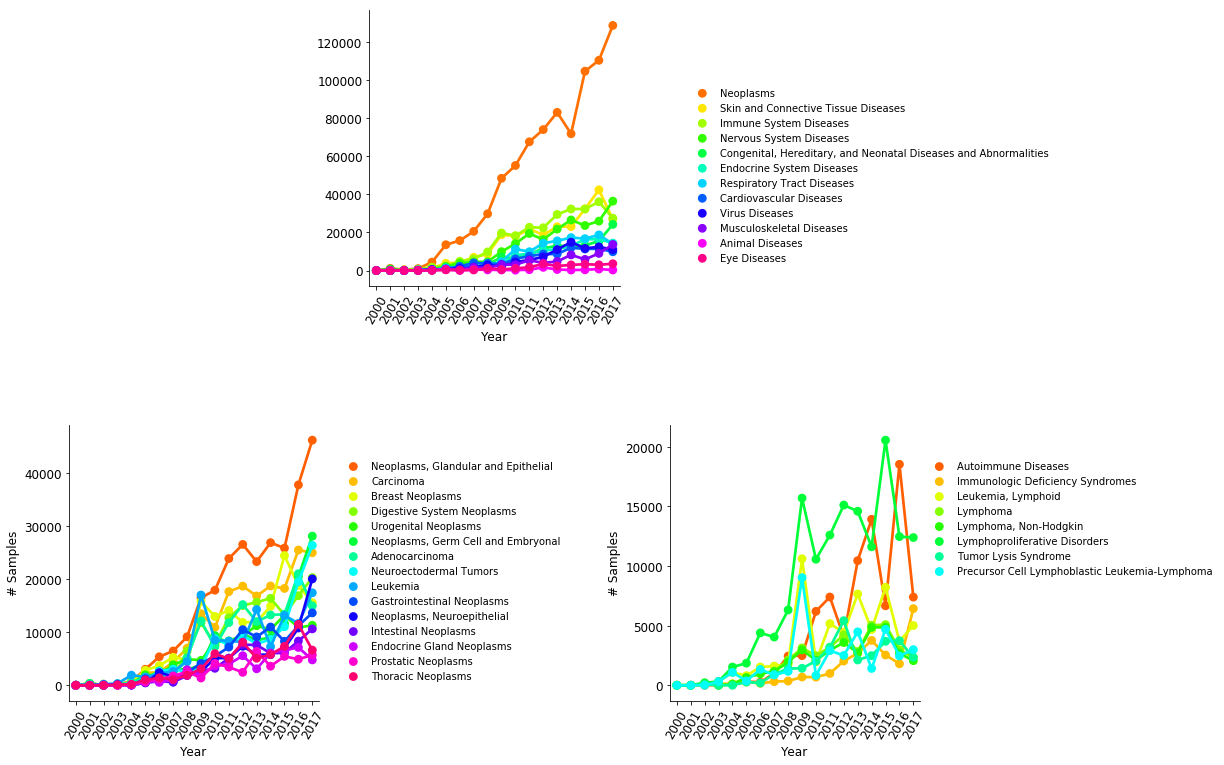

In [5]:
label_font = 12
l1_list = top_d_df.loc[top_d_df.level==1].mesh_heading.unique().tolist()
l1_array = np.array(l1_list)

if counts_or_samples==0:
    plot_df = countdf
    file = 'disease_count_trends.pdf'
    labelz = '# Series'
else:
    plot_df = sampledf
    file = 'disease_sample_trends.pdf'
    labelz = '# Samples'

my_cmap_main = sns.color_palette("hsv",12).as_hex()    
my_cmap_sub = sns.color_palette("hsv",15).as_hex()

vizpath = '../../output/viz'
filename = os.path.join(vizpath, file)

# select disease category for plotting
# e.g. neoplasms, immune system diseases

neoplasm_array = np.array(top_d_df.loc[top_d_df.parent=='Neoplasms'].mesh_heading.unique())[:20]
neoplasm_remove = ['Neoplasm Metastasis','Neoplasms by Histologic Type','Neoplasms by Site','Neoplastic Processes','Carcinogenesis']
neoplasm_array = neoplasm_array[~np.isin(neoplasm_array, neoplasm_remove)]

imm_array = np.array(top_d_df.loc[top_d_df.parent=='Immune System Diseases'].mesh_heading.unique())[:20]
imm_remove = []
imm_array = imm_array[~np.isin(imm_array, imm_remove)]


fig,axs =plt.subplots(2,4, figsize=(20,12))

axs[0,0].remove()

ax = axs[0,1]
sns.pointplot(data=plot_df.loc[np.isin(plot_df.mesh_heading, l1_array),:], x='year', y = 'c', hue='mesh_heading',ax=ax,palette=my_cmap_main, hue_order=l1_array)
ax.set_xticks(range(len(plot_df.year.unique())))
ax.set_xticklabels(plot_df.year.unique(), rotation=60,fontsize=label_font)
ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=label_font)
ax.set_xlabel('Year',fontsize = label_font)
ax.set_ylabel('',fontsize = label_font)
ax.legend(bbox_to_anchor = (2.75,.75),frameon=False)
# move legend here

axs[0,2].remove()
axs[1,1].remove()

ax = axs[1,0]
sns.pointplot(data=plot_df.loc[np.isin(plot_df.mesh_heading, neoplasm_array),:], x='year', y = 'c', hue='mesh_heading',ax=ax,palette=my_cmap_sub, hue_order=neoplasm_array)
ax.set_xticks(range(len(plot_df.year.unique())))
ax.set_xticklabels(plot_df.year.unique(), rotation=60,fontsize=label_font)
ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=label_font)
ax.set_xlabel('Year',fontsize = label_font)
ax.set_ylabel(labelz,fontsize = label_font)
ax.legend(bbox_to_anchor = (2,.9),frameon=False)

ax = axs[1,2]
sns.pointplot(data=plot_df.loc[np.isin(plot_df.mesh_heading, imm_array),:], x='year', y = 'c', hue='mesh_heading',ax=ax,palette=my_cmap_sub)
ax.set_xticks(range(len(plot_df.year.unique())))
ax.set_xticklabels(plot_df.year.unique(), rotation=60,fontsize=label_font)
ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=label_font)
ax.set_xlabel('Year',fontsize = label_font)
ax.set_ylabel(labelz,fontsize = label_font)
ax.legend(bbox_to_anchor = (1,.9),frameon=False)
sns.despine()

axs[0,3].remove()
axs[1,3].remove()

fig.subplots_adjust(left=.1, bottom=.1, right=.9, top=.9, wspace=.2, hspace=.5)

plt.savefig(filename, papertype = 'a4', orientation = 'portrait', format = 'pdf') 

# Area plot for main categories

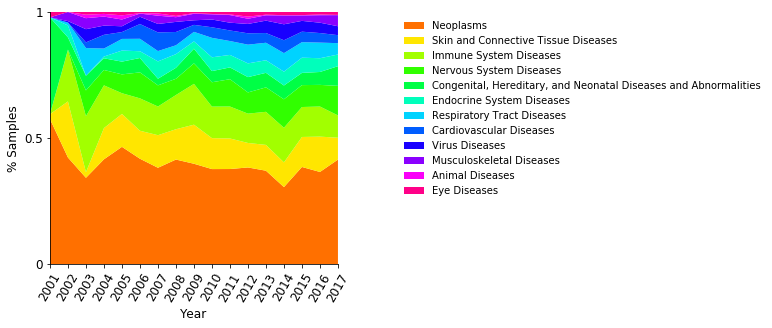

In [6]:
my_cmap_main = sns.color_palette("hsv",12).as_hex()
counts_or_samples = 1

if counts_or_samples==0:
    plot_df = countdf
    file = 'area_plot_counts.pdf'
    labelz = '% Series'
    l1_array = l1_array[~np.isin(l1_array,['Neoplasms'])]
elif counts_or_samples==1:
    plot_df = sampledf
    file = 'area_plot_samples.pdf'
    labelz = '% Samples'

vizpath = '../../output/viz'
filename = os.path.join(vizpath, file)

l1_df = plot_df.loc[(np.isin(plot_df.mesh_heading, l1_list))& (plot_df.year>2000),:].reset_index(drop=True)
df_norm = l1_df.groupby('year').apply(normalise_it)

fig,ax =plt.subplots(1,1, figsize=(10,5))
stack_data = df_norm.groupby('mesh_heading').apply(lambda x: x.c_norm.tolist()).reset_index(name='ts')
stack_data = pd.merge(stack_data,countsdf[['mesh_heading', 'n']], on='mesh_heading', how='left').sort_values('n', ascending=False)
mh = stack_data.mesh_heading
x = df_norm.year.unique()
y = stack_data.ts.tolist()
ax.stackplot(x,y, labels=mh,colors=my_cmap_main)
ax.set_xlim(2001,2017)
ax.set_ylim(0,1)
ax.set_xticks(df_norm.year.unique())
ax.set_xticklabels(df_norm.year.unique(), rotation=60,fontsize=label_font)
ax.set_yticks([0,.5,1])
ax.set_yticklabels([0,.5,1], fontsize=label_font)
ax.set_xlabel('Year',fontsize = label_font)
ax.set_ylabel(labelz,fontsize = label_font)
ax.legend(bbox_to_anchor=[2.5,1],frameon=False)

sns.despine()
fig.subplots_adjust(left=.2, bottom=.2, right=.6, top=.9, wspace=.2, hspace=.2)
plt.savefig(filename, papertype = 'a4', orientation = 'landscape', format = 'pdf')

# Area plot for selected subcategory

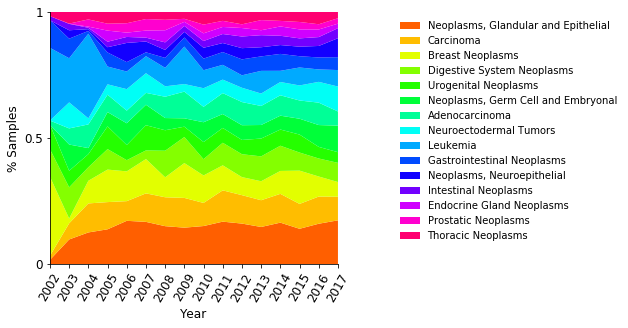

In [8]:
countdf = countdf.drop_duplicates()
sampledf = sampledf.drop_duplicates()
counts_or_samples = 1
my_cmap = sns.color_palette("hsv",15).as_hex()

if counts_or_samples==0:
    plot_df = countdf.loc[np.isin(countdf.mesh_heading, neoplasm_array),:]
    file = 'area_plot_subcategory_counts.pdf'
    labelz = '% Series'
    l1_array = l1_array[~np.isin(l1_array,['Neoplasms'])]
elif counts_or_samples==1:
    plot_df = sampledf.loc[np.isin(sampledf.mesh_heading, neoplasm_array),:]
    file = 'area_plot_subcategory_samples.pdf'
    labelz = '% Samples'

vizpath = '../../output/viz'
filename = os.path.join(vizpath, file)

l1_df = plot_df.loc[plot_df.year>2001,:].reset_index(drop=True)
df_norm = l1_df.groupby('year').apply(normalise_it)
df_norm.loc[df_norm.c_norm.isnull(),'c_norm'] = 0

fig,ax =plt.subplots(1,1, figsize=(10,5))
stack_data = df_norm.groupby('mesh_heading').apply(lambda x: x.c_norm.tolist()).reset_index(name='ts')
stack_data = pd.merge(stack_data,countsdf[['mesh_heading', 'n']].drop_duplicates(), on='mesh_heading', how='left').sort_values('n', ascending=False)
stack_data = stack_data.reset_index(drop=True)
mh = stack_data.mesh_heading
x = df_norm.year.unique()
y = stack_data.ts.tolist()
ax.stackplot(x,y, labels=mh,colors=my_cmap)
ax.set_xlim(2002,2017)
ax.set_ylim(0,1)
ax.set_xticks(df_norm.year.unique())
ax.set_xticklabels(df_norm.year.unique(), rotation=60,fontsize=label_font)
ax.set_yticks([0,.5,1])
ax.set_yticklabels([0,.5,1], fontsize=label_font)
ax.set_xlabel('Year',fontsize = label_font)
ax.set_ylabel(labelz,fontsize = label_font)
ax.legend(bbox_to_anchor=[2,1],frameon=False)

sns.despine()
fig.subplots_adjust(left=.2, bottom=.2, right=.6, top=.9, wspace=.2, hspace=.2)
plt.savefig(filename, papertype = 'a4', orientation = 'landscape', format = 'pdf')

# Plot time series of chemicals studied in conjunction with specific disease
Define mesh id below

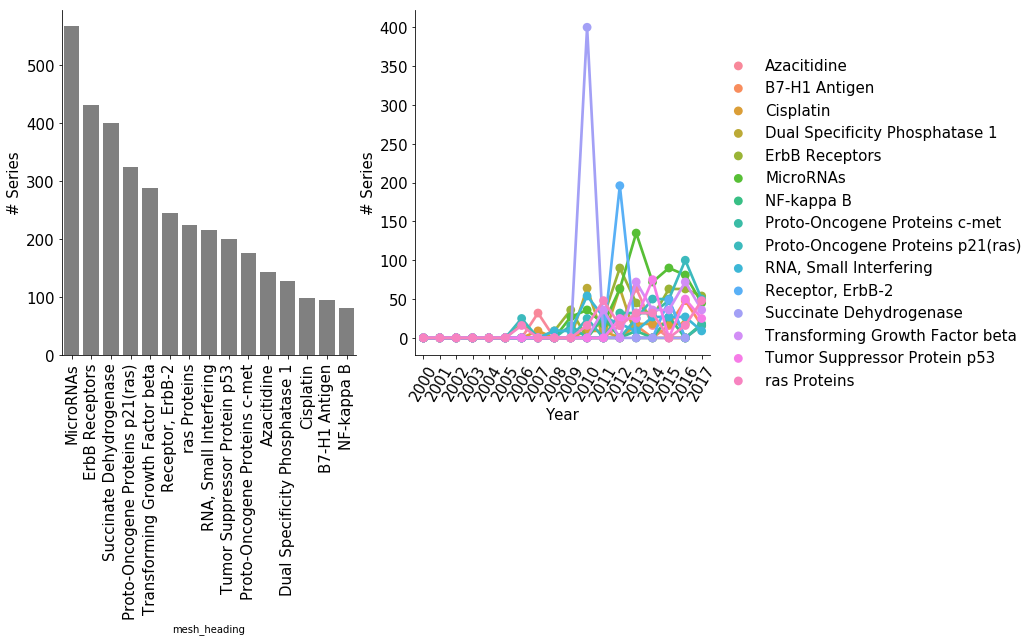

In [9]:
vizpath = '../../output/viz'
file = 'drug_ts_1_disease.pdf'
filename = os.path.join(vizpath, file)

mesh_id = 'D002289' # carcinoma, 'D001943' breast cancer

df1 = query_tags(tadf, [mesh_id], time_range)

df_disease = tadf.loc[np.isin(tadf.geo_id,df1.geo_id.unique()),:]
df_disease = df_disease.loc[df_disease.category=='D',:]

df_chem = df_disease.groupby(['mesh_heading']).count()['geo_id'].sort_values(ascending=False)[:15]
df_chem = df_chem.reset_index(name = 'n')

chem_time = df_disease.groupby(['mesh_heading', 'year']).count()['geo_id']
chem_time = chem_time.reset_index(name = 'n')
chem_list = df_chem.mesh_heading.tolist()
p = chem_time.loc[np.isin(chem_time.mesh_heading, chem_list),:]
p = p.groupby('mesh_heading').apply(lambda x:add_all_years(x, time_range))

label_font = 15
fig,axs =plt.subplots(1,2, figsize=(18,12))

ax = axs[0]
sns.barplot(data=df_chem, x='mesh_heading', y='n',ax=ax,color=[.5,.5,.5])
ax.set_xticks(range(len(df_chem.mesh_heading.unique())))
ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=label_font)
ax.set_xticklabels(df_chem.mesh_heading.unique(), rotation=90,fontsize=label_font)
ax.set_ylabel('# Series',fontsize = label_font)

ax = axs[1]
sns.pointplot(data = p, x='year', y='n', hue='mesh_heading',ax=ax)
ax.set_xticks(range(len(p.year.unique())))
ax.set_xticklabels(p.year.unique(), rotation=60,fontsize=label_font)
ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=label_font)
ax.set_xlabel('Year',fontsize = label_font)
ax.set_ylabel('# Series',fontsize = label_font)
ax.legend(bbox_to_anchor = (1,.9),frameon=False,fontsize=label_font)

sns.despine()
fig.subplots_adjust(left=.1, bottom=.5, right=.6, top=.9, wspace=.2, hspace=.1)

plt.savefig(filename, papertype = 'a4', orientation = 'portrait', format = 'pdf')